<br>Dora Li
<br>CS315 
<br>April 23rd, 2024

# Understanding Seasonality in TikTok Advertisements 
**Table of Content**

1. [Load the data](#sec1)  
2. [Convert to document-term matrix](#sec2)  
3. [Fit the LDA model and explore it](#sec3)
4. [Generating relevant results](#sec4)


<a id="sec1"></a>
## 1. Load the data
We first load the relevant data and get advertisement and nonadvertisement subsets into dataframes

In [1]:
import pandas as pd
import numpy as np

In [42]:
def getAds(filename):
    """
    Takes in a csv file and return advertisement a dataframe
    """
    df = pd.read_csv(filename)
    df.drop_duplicates(subset=['Date','Link'],inplace=True,keep='first',ignore_index=True)
    ads = df[df["video_is_ad"] == True]
    ads = ads.fillna("") # make sure there is no na values
    ads['video_time_watched'] = ads['Date']
    ads.drop(['Date'],  axis=1, inplace = True)
    return ads

def getVid(filename):
    """
    Takes in a csv file and return regular videos a dataframe
    """
    df = pd.read_csv(filename)
    df.drop_duplicates(subset=['Date','Link'],inplace=True,keep='first',ignore_index=True)
    vid = df[df["video_is_ad"] == False]
    vid = vid.fillna("") # make sure there is no na values
    vid['video_time_watched'] = vid['Date']
    vid.drop(['Date'],  axis=1, inplace = True)
    return vid


In [37]:
def getWordDescrip(row):
    """
    Generate new row that combine the suggested words and descriptions
    """
    return row['suggested_words'] + row['video_description']

In [43]:
ads10824 = getAds("merged_10824.csv")
ads10824["all_description"] = ads10824.apply(getWordDescrip, axis=1)
vid10824 = getVid("merged_10824.csv")
vid10824["all_description"] = vid10824.apply(getWordDescrip, axis=1)

ads12345 = getAds("merged_12345.csv")
ads12345["all_description"] = ads12345.apply(getWordDescrip, axis=1)
vid12345 = getVid("merged_12345.csv")
vid12345["all_description"] = vid12345.apply(getWordDescrip, axis=1)

ads26301 = getAds("merged_26301.csv")
ads26301["all_description"] = ads26301.apply(getWordDescrip, axis=1)
vid26301 = getVid("merged_26301.csv")
vid26301["all_description"] = vid26301.apply(getWordDescrip, axis=1)

ads33534 = getAds("merged_33534.csv")
ads33534["all_description"] = ads33534.apply(getWordDescrip, axis=1)
vid33534 = getVid("merged_33534.csv")
vid33534["all_description"] = vid33534.apply(getWordDescrip, axis=1)

ads50405 = getAds("merged_50405.csv")
ads50405["all_description"] = ads50405.apply(getWordDescrip, axis=1)
vid50405 = getVid("merged_50405.csv")
vid50405["all_description"] = vid50405.apply(getWordDescrip, axis=1)

In [3]:
# def clean_description(row):
#     delete = ['fyp', 'foryou', 'fy', 'fypage', 'foryoupage', 'viral','trending','tiktok']
#     for txt in delete:
#         result = row['video_description'].replace(txt, "")
#     return result

In [ ]:
# vid10824['video_description'] = vid10824.apply(clean_description, axis =1)
# vid12345['video_description'] = vid12345.apply(clean_description, axis =1)
# vid26301['video_description'] = vid26301.apply(clean_description, axis =1)
# vid33534['video_description'] = vid33534.apply(clean_description, axis =1)
# vid50405['video_description'] = vid50405.apply(clean_description, axis =1)

<a id="sec2"></a>
## 2. Convert to document-term matrix

Afterwards, we will apply the CountVectorizer to convert our advertisement and nonads corpus into document-term matrices and get the features.

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
def getDtmFeature(column):
    """
    Takes in a dataframe column and returns the dtm along with the associated feature names
    """
    # Initialize the vectorizer
    vectorizer = CountVectorizer(
    strip_accents='unicode',
    stop_words='english',
    lowercase=True,
    token_pattern=r'\b[a-zA-Z]{3,}\b', # we want only words that contain letters and are 3 or more characters long
    )
    
    # Transform our data into the document-term matrix
    dtm = vectorizer.fit_transform(column)
    
    # Get the feature names
    feature_names = vectorizer.get_feature_names_out()
    
    return dtm, feature_names

In [ ]:
# dtm_ads10824, feature_ads10824 = getDtmFeature(ads10824['video_description'])
# dtm_vid10824, feature_vid10824 = getDtmFeature(vid10824['video_description'])

# dtm_ads12345, feature_ads12345 = getDtmFeature(ads12345['video_description'])
# dtm_vid12345, feature_vid12345 = getDtmFeature(vid12345['video_description'])

# dtm_ads26301, feature_ads26301 = getDtmFeature(ads26301['video_description'])
# dtm_vid26301, feature_vid26301 = getDtmFeature(vid26301['video_description'])

# dtm_ads33534, feature_ads33534 = getDtmFeature(ads33534['video_description'])
# dtm_vid33534, feature_vid33534 = getDtmFeature(vid33534['video_description'])

# dtm_ads50405, feature_ads50405 = getDtmFeature(ads50405['video_description'])
# dtm_vid50405, feature_vid50405 = getDtmFeature(vid50405['video_description'])

### Going back to the dataframe
This section checks for the terms used in each document term matrices and is NOT used when running the whole thing

In [9]:
def matrix2Doc(dtm, features, index):
    """
    Takes the representation of each document as a row of numbers in the matrix and return it back to a list of words.
    """
    row = dtm.getrow(index).toarray()
    non_zero_indices = row.nonzero()[1]
    words = [features[idx] for idx in non_zero_indices]
    
    return words

def getTerm(df):
    """
    Takes in a dataframe, returns all the terms in the dtm from the dtm
    """
    # list of terms to be removed
    delete = ['fyp', 'foryou', 'fy', 'fypage', 'foryoupage', 'viral','trending','tiktok']
    
    # get dtm and feature words from the video descriptions
    dtm, feature = getDtmFeature(df['video_description'])
    
    # get individual terms in the dtm and make sure that the terms are not in delete
    allVidAsTerms = []
    for i in range(dtm.shape[0]):
        for word in matrix2Doc(dtm, feature, i):
            if word not in delete:
                allVidAsTerms.append(word)
    
    # create a new column that contains the relevant terms in the dtm matrix for each row (video)
    df['terms'] = allVidAsTerms
    
    return df

In [ ]:
# ads10824 = getTerm(ads10824)
# vid10824 = getTerm(vid10824)

# ads12345 = getTerm(ads12345)
# vid12345 = getTerm(vid12345)

# ads26301 = getTerm(ads26301)
# vid26301 = getTerm(vid26301)

# ads33534 = getTerm(ads33534)
# vid33534 = getTerm(vid33534)

# ads50405 = getTerm(ads50405)
# vid50405 = getTerm(vid50405)

<a id="sec3"></a>
## 3. Fit the LDA model
Here, we generate first a dataframe that summarizes the topics for each video and then find most relevant topics and how many videos are in each group as well as the general terms used for that topic.

In [10]:
from sklearn.decomposition import LatentDirichletAllocation

In [11]:
def displayHeader(model, features, no_top_words):
    """
    Takes in the lda model, the relevant features and the number of top words to show
    and returns the list of topic names
    """
    topicNames = []
    # Go through the model components/ key terms and select the top key terms
    for topic_idx, topic in enumerate(model.components_):
        topicNames.append(f"Topic {topic_idx}: " + (", ".join([features[i]
                             for i in topic.argsort()[:-no_top_words-1:-1]])))
    return topicNames

In [78]:
def getDocumentTopic(df, num):
    """
    Takes the dataframe dtm and returns a dataframe with row being the document and the column being 
    the probability of being in a specific topic
    """
    # get dtm and feature
    dtm, features =  getDtmFeature(df["all_description"])
    
    # Initialize the model
    lda = LatentDirichletAllocation(n_components=num, # we are picking the number of topics arbitrarely at the moment
                                random_state=0)
    # Fit the model
    lda.fit(dtm)
                     
    # Get document topic list (prob of being in which topic grp)
    doc_topic_dist = lda.transform(dtm)
    
    # column names
    topicnames = displayHeader(lda, features, 5)

    # Use the video ids as the document name
    docnames = df["video_id"].tolist()
    
    # Make the pandas dataframe
    df_document_topic = pd.DataFrame(np.round(doc_topic_dist, 3), 
                                     columns=topicnames, 
                                     index=docnames)

    # Get dominant topic for each document
    dominant_topic = np.argmax(df_document_topic.values, axis=1) # finds the maximum argument
    df_document_topic['dominant_topic'] = dominant_topic
    df_document_topic['video_id'] = df_document_topic.index
    
    # Merge documents
    dff = df_document_topic.merge(df, on = ['video_id'])
    return dff

In [79]:
getDocumentTopic(ads10824, 10)

,"Topic 0: hair, wig, holiday, kitchen, ekane","Topic 1: unbrush, brush, hair, detangling, holiday","Topic 2: season, hair, shop, new, need","Topic 3: expats, talks, disney, tony, taurus","Topic 4: shadow, vinyl, holiday, journal, baby","Topic 5: twe, oreo, cheesecake, davido, tarts","Topic 6: cookies, oats, cookie, oatmeal, quaker","Topic 7: birthday, grinch, hbcu, football, dance","Topic 8: fever, psychic, jimmy, just, boy","Topic 9: skin, pepsi, care, skincare, maybelline",...,author_username,author_name,author_followercount,author_followingcount,author_heartcount,author_videocount,author_diggcount,author_verified,video_time_watched,all_description
0,0.005,0.005,0.005,0.005,0.957,0.005,0.005,0.005,0.005,0.005,...,abs.tract_,abs.tract_,,,,,,False,2024-02-26 22:22:30,Prioritising healthy hair all year long with t...
1,0.003,0.003,0.003,0.003,0.977,0.003,0.003,0.003,0.003,0.003,...,kartierkloe,𝗠𝗜𝗦𝗦 𝗛𝗢𝗟𝗟𝗬𝗪𝗢𝗢𝗗,,,,,,False,2024-02-26 16:06:22,"Shadow Work Journal, the shadow work journal, ..."
2,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.974,0.003,0.003,...,joshleviworld,JOSH LEVI,,,,,,True,2024-02-26 13:24:32,"birthday dance josh levi, howard university, H..."
3,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.925,0.008,0.008,...,thatssofetchau,THATSSOFETCH,,,,,,False,2024-02-26 05:32:40,When should we drop these? 👀🤍 The ‘Bamba Set’ ...
4,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.957,0.005,0.005,...,asos,asos,,,,,,False,2024-02-26 05:32:35,"asos, Must Haves, ASOS Clothes, brands, Clothe..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,0.020,0.020,0.820,0.020,0.020,0.020,0.020,0.020,0.020,0.020,...,Target,Target,,,,,,False,2023-12-11 18:50:09,"New top deals to score, now through Saturday"
311,0.011,0.011,0.011,0.900,0.011,0.011,0.011,0.011,0.011,0.011,...,PopCorners,PopCorners,,,,,,False,2023-12-11 18:49:36,Simplicity that’s bound to satisfy. Snack diff...
312,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.972,0.003,0.003,...,clearstemskincare,CLEARSTEM Skincare,,,,,,True,2023-12-11 18:49:00,"Clearstem Acne Supplement, Clearstem, skincare..."
313,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.979,...,tabitha.blue,TabithaBlue,,,,,,False,2023-12-11 18:48:28,#ad My skincare secret: @Olay Skin Care Vitami...


In [51]:
def getDocumentTopicHelper(df,dtm,features,lda):
    """
    Takes the dataframe dtm and returns a dataframe with row being the document and the column being 
    the probability of being in a specific topic
    """
    # Get document topic list (prob of being in which topic grp)
    doc_topic_dist = lda.transform(dtm)
    
    # column names
    topicnames = displayHeader(lda, features, 5)

    # Use the video ids as the document name
    docnames = df["video_id"].tolist()
    
    # Make the pandas dataframe
    df_document_topic = pd.DataFrame(np.round(doc_topic_dist, 3), 
                                     columns=topicnames, 
                                     index=docnames)

    # Get dominant topic for each document
    dominant_topic = np.argmax(df_document_topic.values, axis=1) # finds the maximum argument
    df_document_topic['dominant_topic'] = dominant_topic

    return df_document_topic

In [48]:
def display_top10_word_in_topics(row, model, features, no_top_words):
    """
    Takes in row, model, feature, no of top words to show the top 10 words in a topic
    """
    # list of terms to remove
    delete = ['fyp', 'foryou', 'fy', 'fypage', 'foryoupage', 'viral','trending','tiktok','relatable', 'goviral']
    
    # Get the topic group based on the topic index
    for topic_idx, topic in enumerate(model.components_):
        if row["TopicNum"] == topic_idx:
            words = [features[i] for i in topic.argsort()]
    
    # Remove the terms in delete from the string of terms
    result = []
    for word in words:
        if word not in delete:
            result.append(word)
    
    # syntax for reversing a list [::-1]
    return " ".join(result[:-no_top_words-1:-1])
    
# def display_doc(row):
#     """
#     Display the document names associated with the topic
#     """
#     docs = row[row['dominant_topic'] == row['TopicNum']]
#     return docs.index.tolist()



In [50]:
def getTopicDist(df,num):
    """
    Takes in document topic dataframe and no of topics to return a topic distribution table
    """
    # get dtm and feature
    dtm, features =  getDtmFeature(df["all_description"])
    
    # Initialize the model
    lda = LatentDirichletAllocation(n_components=num, # we are picking the number of topics arbitrarely at the moment
                                random_state=0)
    # Fit the model
    lda.fit(dtm)
    
    # get df_document_topic
    df_document_topic = getDocumentTopicHelper(df,dtm, features)
    
    # Count the number of videos with dominant topic being the topic num
    df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
    
    # Set the column names
    df_topic_distribution.columns = ['TopicNum', 'NumDocuments']
    
    # Add column to show the top 10 terms for the topic
    df_topic_distribution['top10'] = df_topic_distribution.apply(display_top10_word_in_topics,args= (lda, features,10), axis=1)
    
    # df_topic_distribution['docs'] = df_topic_distribution.apply(display_doc, axis=1)
    
    return df_topic_distribution

In [56]:
getTopicDist(ads10824, 10)

,TopicNum,NumDocuments,top10
0,7,39,birthday grinch hbcu football dance perfume as...
1,8,32,fever psychic jimmy just boy burna dat like da...
2,6,31,cookies oats cookie oatmeal quaker gift butter...
3,9,31,skin pepsi care skincare maybelline period cot...
4,1,30,unbrush brush hair detangling holiday tree hut...
5,2,28,season hair shop new need color target favorit...
6,3,28,expats talks disney tony taurus approved derma...
7,4,27,shadow vinyl holiday journal baby work cheese ...
8,0,23,hair wig holiday kitchen ekane fall cleaning n...
9,5,16,twe oreo cheesecake davido tarts make flyana b...


<a id="sec4"></a>
## 4. Generating relevant results

In [44]:
# create dataframe for all the ads
ads = pd.concat([ads10824, ads12345, ads26301, ads33534,ads50405])
ads.head()

,Unnamed: 0.1,Link,video_id,Unnamed: 0,video_timestamp,video_duration,video_locationcreated,suggested_words,video_diggcount,video_sharecount,...,author_username,author_name,author_followercount,author_followingcount,author_heartcount,author_videocount,author_diggcount,author_verified,video_time_watched,all_description
657,1154.0,https://www.tiktokv.com/share/video/7332202104...,7332202104519445792,694,2024-02-05T14:29:02,35.0,GB,,794.0,7.0,...,abs.tract_,abs.tract_,,,,,,False,2024-02-26 22:22:30,Prioritising healthy hair all year long with t...
1544,2045.0,https://www.tiktokv.com/share/video/7283158241...,7283158241054330155,1579,2023-09-26T11:33:49,5.0,US,"Shadow Work Journal, the shadow work journal, ...",877100.0,4725.0,...,kartierkloe,𝗠𝗜𝗦𝗦 𝗛𝗢𝗟𝗟𝗬𝗪𝗢𝗢𝗗,,,,,,False,2024-02-26 16:06:22,"Shadow Work Journal, the shadow work journal, ..."
1842,2343.0,https://www.tiktokv.com/share/video/7338895866...,7338895866134138143,1877,2024-02-23T15:25:14,28.0,US,"birthday dance josh levi, howard university, H...",40000.0,170.0,...,joshleviworld,JOSH LEVI,,,,,,True,2024-02-26 13:24:32,"birthday dance josh levi, howard university, H..."
2415,2916.0,https://www.tiktokv.com/share/video/7270661407...,7270661407039819010,2450,2023-08-23T19:19:43,10.0,AU,,13000.0,336.0,...,thatssofetchau,THATSSOFETCH,,,,,,False,2024-02-26 05:32:40,When should we drop these? 👀🤍 The ‘Bamba Set’ ...
2419,2920.0,https://www.tiktokv.com/share/video/7338473378...,7338473378069744897,2454,2024-02-22T12:04:45,11.0,FAKE-AD,"asos, Must Haves, ASOS Clothes, brands, Clothe...",257.0,4.0,...,asos,asos,,,,,,False,2024-02-26 05:32:35,"asos, Must Haves, ASOS Clothes, brands, Clothe..."


In [69]:
getTopicDist(ads12345,15)

,TopicNum,NumDocuments,top10
0,14,165,recipes cup hinge oats explore dating binaries...
1,10,153,order code orders door dash movie barbie abiga...
2,6,145,delivery food meal easy quick water dresses fa...
3,7,141,deodorant things poor movie body swift taylor ...
4,9,131,retinol monopoly game disney new zendaya free ...
5,4,125,skin skincare routine care diaper granola live...
6,12,121,gift climbing girl olay pepsi body hill climb ...
7,5,117,design canva app feeling lose target sydney co...
8,3,111,pepper abbott elementary new megan thee pixel ...
9,1,100,brothers comedy sun paul scott trailer mescal ...


In [73]:
# look at valentines related ads distribution
ads12345['video_time_watched'] = pd.to_datetime(ads12345['video_time_watched'])
print(ads12345.groupby(ads12345['video_time_watched'].dt.to_period('D')).size()) #this is to print out counts of all the videos by date

start_date = '2023-12-10'
end_date = '2024-01-10'
filtereddf = ads12345[(ads12345['video_time_watched'] >= start_date) & (ads12345['video_time_watched'] <= end_date)]
print(filtereddf.groupby(filtereddf['video_time_watched'].dt.to_period('D')).size()) #printing out counts of videos within time period

video_time_watched
2023-09-09     3
2023-09-12     4
2023-09-15     1
2023-09-16     2
2023-09-17     1
              ..
2024-03-03    25
2024-03-04    10
2024-03-05    18
2024-03-06    19
2024-03-07     9
Freq: D, Length: 110, dtype: int64
video_time_watched
2023-12-10     2
2023-12-11    34
2023-12-12    42
2023-12-13    50
2023-12-14    33
2023-12-15    58
2023-12-16    38
2023-12-17    42
2023-12-18    35
2023-12-19    21
2023-12-20    21
2023-12-21    23
2023-12-22    38
2023-12-23     1
2023-12-25     1
2024-01-02    13
2024-01-03    11
2024-01-04    12
2024-01-05    10
2024-01-06    13
2024-01-07    30
2024-01-08     4
2024-01-09    11
Freq: D, dtype: int64


In [74]:
getTopicDist(filtereddf,15)

,TopicNum,NumDocuments,top10
0,5,60,door dash order code orders new things poor ra...
1,12,58,skin skincare routine care serum night sponsor...
2,14,40,delivery design canva meal food app olay graph...
3,9,38,starbucks college game dove citizens antipersp...
4,11,37,code order make orders food homeget hair baby ...
5,7,37,best holiday let brennan lee dimension mulliga...
6,13,36,monopoly game disney december percy olympians ...
7,0,34,barbie bag tote robbie margot movie period cos...
8,1,33,pepper cream day mascara bachelor tuition than...
9,6,33,piercing popcorners bag crunch watch snack fou...


In [111]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [101]:
ads12345['video_time_watched'] = pd.to_datetime(ads12345['video_time_watched'])
df = getDocumentTopic(ads12345, 10)

In [102]:
df = ads12345.groupby(ads12345['video_time_watched'].dt.to_period('D')).size()
print(ads12345.groupby(ads12345['video_time_watched'].dt.to_period('D')).size())

video_time_watched
2023-09-09     3
2023-09-12     4
2023-09-15     1
2023-09-16     2
2023-09-17     1
              ..
2024-03-03    25
2024-03-04    10
2024-03-05    18
2024-03-06    19
2024-03-07     9
Freq: D, Length: 110, dtype: int64


In [107]:
d1 = getDocumentTopic(ads12345, 10)
vid_counts = df.groupby('video_time_watched').value_counts().sort_index().reset_index()
d1['count'] = vid_counts['level_1']

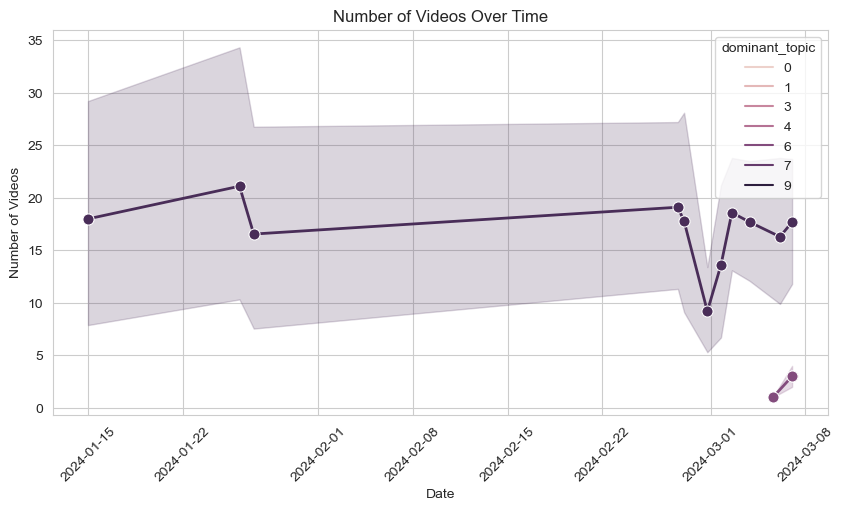

In [112]:
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")
sns.lineplot(data=d1, x='video_time_watched',y='count',
             hue='dominant_topic',marker='o',linewidth=2, markersize=8)
plt.xlabel('Date')
plt.ylabel('Number of Videos')
plt.title('Number of Videos Over Time')
plt.xticks(rotation=45)
plt.show()

In [89]:
fig = px.histogram(df, x="video_time_watched",color="dominant_topic", barmode="group")
fig.show()